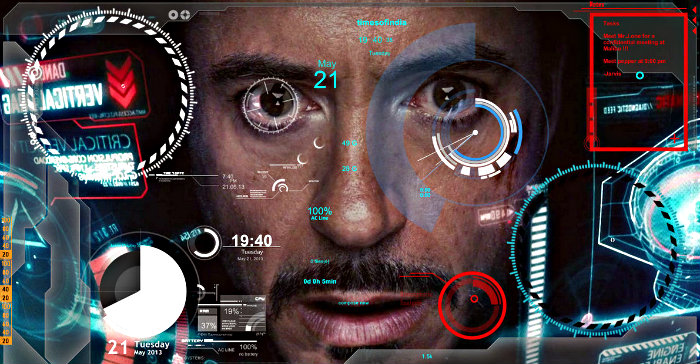

- Analyst Agent (решает: нужна команда)
- Command Agent (генерирует код)
- Colab Runtime (исполняет)

In [ ]:
# %%capture
# !pip -q install -qU langchain==0.3.27 langchain-mistralai==0.2.12 python-dotenv==1.1.1 langgraph==0.2.19 mistralai faiss-cpu==1.13.2 sentence-transformers==5.2.2

In [ ]:
from google.colab import userdata
MISTRAL_API_KEY = userdata.get("MISTRAL_API_KEY")

Настройка mistral<br>
Изменения в новой версии https://github.com/mistralai/client-python/blob/main/MIGRATION.md

In [ ]:
from mistralai.client import MistralClient
from mistralai import Mistral, UserMessage, SystemMessage
import uuid
import json
import faiss
from sentence_transformers import SentenceTransformer

client = Mistral(api_key=MISTRAL_API_KEY)

def mistral_chat(system, user):
    resp = client.chat.complete(
        model="mistral-large-latest",
        messages=[
            SystemMessage(role="system", content=system),
            UserMessage(role="user", content=user)
        ]
    )
    return resp.choices[0].message.content.strip()

In [ ]:
class MemoryAgent:
    def __init__(self, dim=384):
        self.model = SentenceTransformer("all-MiniLM-L6-v2")
        self.index = faiss.IndexFlatL2(dim)
        self.store = {}

    def add(self, text: str):
        emb = self.model.encode([text])
        self.index.add(emb)
        self.store[self.index.ntotal - 1] = text

    def search(self, query: str, k=3):
        if self.index.ntotal == 0:
            return []
        q_emb = self.model.encode([query])
        _, idx = self.index.search(q_emb, k)
        return [self.store[i] for i in idx[0] if i in self.store]

In [ ]:
class RetrieverAgent:
    def __init__(self, docs):
        self.docs = docs
        self.model = SentenceTransformer("all-MiniLM-L6-v2")
        emb = self.model.encode(docs)

        self.index = faiss.IndexFlatL2(emb.shape[1])
        self.index.add(emb)

    def search(self, query, k=3):
        q_emb = self.model.encode([query])
        _, idx = self.index.search(q_emb, k)
        return [self.docs[i] for i in idx[0]]

In [ ]:
class ColabExecutor:
    def run(self, code: str):
        try:
            local_env = {}
            exec(code, {}, local_env)
            return {
                "status": "success",
                "output": str(local_env)
            }
        except Exception as e:
            return {
                "status": "error",
                "traceback": str(e)
            }

In [ ]:
def command_agent(task: str, memory: MemoryAgent, executor: ColabExecutor):
    # 1. генерация кода
    code = client.chat.complete(
        model="mistral-large-latest",
        messages=[
            {"role": "system", "content": "Сгенерируй Python-код. Только код."},
            {"role": "user", "content": task}
        ]
    ).choices[0].message.content

    # 2. выполнение
    result = executor.run(code)

    # 3. автодебаг
    retries = 2
    while result["status"] == "error" and retries > 0:
        code = client.chat.complete(
            model="mistral-large-latest",
            messages=[
                {"role": "system", "content": "Исправь ошибку и верни только код."},
                {"role": "user", "content": f"Код:\n{code}\nОшибка:\n{result['traceback']}"}
            ]
        ).choices[0].message.content

        result = executor.run(code)
        retries -= 1

    # 4. ревью
    review = client.chat.complete(
        model="mistral-large-latest",
        messages=[
            {"role": "system", "content": "Сделай краткое техническое ревью."},
            {"role": "user", "content": f"Код:\n{code}\nРезультат:\n{result}"}
        ]
    ).choices[0].message.content

    memory.add(f"Task: {task}\nCode:\n{code}\nResult:\n{result}")

    return f"{result}\n\nREVIEW:\n{review}"

In [ ]:
functions = [
    {
        "name": "search_docs",
        "description": "Поиск по документации",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {"type": "string"}
            },
            "required": ["query"]
        }
    },
    {
        "name": "run_code",
        "description": "Сгенерировать и выполнить код",
        "parameters": {
            "type": "object",
            "properties": {
                "task": {"type": "string"}
            },
            "required": ["task"]
        }
    },
    {
        "name": "final_answer",
        "description": "Финальный ответ пользователю",
        "parameters": {
            "type": "object",
            "properties": {
                "answer": {"type": "string"}
            },
            "required": ["answer"]
        }
    }
]

In [ ]:
def dispatch(name, args, retriever, memory, executor):
    if name == "search_docs":
        return "\n".join(retriever.search(args["query"]))

    if name == "run_code":
        return command_agent(args["task"], memory, executor)

    if name == "final_answer":
        return args["answer"]

    raise ValueError(name)

In [ ]:
import json

def jarvis_loop(user_input, retriever, memory, executor):
    messages = [
        {"role": "system", "content": (
            "Ты JARVIS — AI ассистент программиста.\n"
            "Если нужно выполнить задачу, ответь строго в JSON формате:\n"
            '{"action": "run_code"|"search_docs"|"final_answer", "args": {...}}'
        )},
        {"role": "user", "content": user_input}
    ]

    while True:
        response = client.chat.complete(
            model="mistral-large-latest",
            messages=messages
        )

        msg_text = response.choices[0].message.content.strip()

        # Пытаемся разобрать JSON
        try:
            msg_json = json.loads(msg_text)
            action = msg_json.get("action")
            args = msg_json.get("args", {})
        except Exception:
            # Если LLM не вернул JSON, выдаём как финальный ответ
            memory.add(f"USER: {user_input}\nASSISTANT: {msg_text}")
            return msg_text

        # Диспетчер
        result = dispatch(action, args, retriever, memory, executor)

        # добавляем результат в контекст для следующего шага
        messages.append({"role": "assistant", "content": msg_text})
        messages.append({"role": "function", "name": action, "content": str(result)})

In [ ]:
docs = [
    "RandomForest — ансамблевый метод машинного обучения.",
    "Accuracy — доля правильных ответов.",
    "FAISS используется для векторного поиска."
]

In [ ]:
retriever = RetrieverAgent(docs)
memory = MemoryAgent()
executor = ColabExecutor()

answer = jarvis_loop(
    "Обучи RandomForest на iris и выведи accuracy",
    retriever,
    memory,
    executor
)

print(answer)

```json
{
  "action": "run_code",
  "args": {
    "code": "from sklearn.datasets import load_iris\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Загрузка данных\niris = load_iris()\nX, y = iris.data, iris.target\n\n# Разделение на обучающую и тестовую выборки\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Обучение модели\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train, y_train)\n\n# Предсказание и расчет accuracy\ny_pred = model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\n\n# Вывод результата\nprint(f\"Accuracy: {accuracy:.4f}\")",
    "description": "Обучение RandomForest на датасете iris и вывод accuracy."
  }
}
```
